In this tutorial, we'll walk through running a neural network on genome data.

This part won't be very iPython tutorial-ly...

First cd in the terminal over to the data directory and have a look to our data.

In [26]:
!ls;

README.md                        learnseq.ipynb
humanvsran                       predict_seq.py
humanvsran_label                 rollin-wild-giraffe-klonblog.jpg


Here you will find four files:<br><font color="#417EAE">humanvsran</font>: contain human 10,000 human sequences and 10,000 random sequences generated by RSAT random-seq.<br><font color="#417EAE">humanvsran_label</font>: labels for <font color="#417EAE">humanvsran</font>, where 1 stands for human sequences and 0 stands for random sequences.<br><font color="#417EAE">predict_seq.py</font>: python code for our CNN.<br><font color="#417EAE">learnseq.ipynb</font>: that's me!



Now lets have a look to our data!

In [27]:
!head humanvsran -n 3

==> humanvsran <==
CTACTCGGGAGGCTGAGGCAGGAGAATCACTTGAACCAGGGAGTCAGAGGTTGCAGTGAGCCAAGATCGCACCACTGCACTCCAGCCTGGCAACACAGCGAGAGTCTGTCTCCAAAAAAAAAAAAAAAGGCCCAAGAGCATTTCAAACTGTTTGTTGAGAGGTAATCTTATACATTCAGTTTCTTTTGGCTTACCTGAAGAGGTGCTTGGCTATGGTTAACAAACTACGTAAGCTGGTGAAAAAACCTGT
CACCTTATCCAGAGAAGCTTCTTCTTTTAGAAAATCAAGCAAAACAACTAAGCCAAGACATGTTAAAAAAAAAGTTTGAAAAGAAAGCTGTAAGGAAATACAAGGGGAGGGATTGTTAGATATGAGTTCTAAATTTCTTTTCAAAAAATCGATATGTCAGTATGTTCAATTCTTTGCCTTCTACTTTTAAACTTCCTCATAAAGCAACCTTTTTCAATTACCTGCTCCACCCTGACTCATTCTGATCACC
AAAGGGGCTGATAGAAAAATAAAGAGATTTGGCCAGGTACGGTGGCTCACTCCTGTAATCCCAGCACTTTGGGAGGCCGAGGCTGGCGGATCACCTGAGGTCGGGAGTTCGAGACCAGCCTGACCAACATGGAGAACCCCTGTCTCTACTAAAATTACAAAATTAGCCAGGCATGGTGGCACATGTCTGTAATCCCAGCTACTTGGGAGGCTGAGGCAGGAGGATCATTTGAACCAGGGAGGCAGAGGTT
AAGTGGATATTCAGACCTCCTTGAGGCCTTCGTTGGAAACGGGATTTCTTCATATTCTGCTAGACAGAAGAATTCTCAGTAACTTCCTTGTGTTGTGTGTATTCAACTCAAAGAGTTCAACGATCCTTTATACAGAGCAGACTTGAAACACTCTTTTTGTGGAATTTGCAAATGGAGATCTCAGCCGCTTTGTGGTCAGTAGTAGAAAAGGAAATATCTTCGTATAAA

These are sequences randomly cut from human chromosome 1. Now have a look to the label file also.

In [28]:
!head humanvsran_label -n 3

==> humanvsran_label <==
1
1
1
1
1
1
1
1
1
1
head: -n: No such file or directory
head: 3: No such file or directory


All 1s since they are all human sequence, so if you 'tail' the file, it will be all zeros!

Now lets begin to train our predict_seq program! First import some libraries.

In [38]:
import numpy as np
import os
import tensorflow as tf
import sys
import re
import random

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, MaxPooling1D
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [61]:
f = open('humanvsran', "r")
lines = f.readlines()
f.close()

for i in range(len(lines)):
    tem = lines[i].rstrip()
    print(tem)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 7)

Read our sequence and label file.

In [52]:
##Read data
f = open('humanvsran_label', "r")
lines = f.readlines()
f.close()
dat_y = np.zeros((len(lines),2))
for i in range(len(lines)):
	#dat_y[i] = float(dat_y[i].rstrip())
	dat_y[i,int(lines[i].rstrip())] = 1

f = open('humanvsran', "r")
lines = f.readlines()
f.close()

def DNA_matrix(seq):
	tem2 = ['[aA]','[cC]','[gG]','[tT]']
	for i in range(len(tem2)):
		ind = [m.start() for m in re.finditer(tem2[i], seq)]
		tem = np.zeros(len(seq),dtype=np.int)
		tem[ind] = 1
		if i==0:
			a = np.zeros((len(seq),4))
		a[...,i] = tem
	return a

for i in range(len(lines)):
	tem = lines[i].rstrip()
	if i==0:
		dat_x = np.zeros((len(lines),len(tem),4))
	dat_x[i,] = DNA_matrix(tem)


ind = list(range(20000))
random.shuffle(ind)
x_train=dat_x[ind[0:12000]]
y_train=dat_y[ind[0:12000]]
x_val=dat_x[ind[12001:14001]]
y_val=dat_y[ind[12001:14001]]
x_test=dat_x[14001:20001]
y_test=dat_y[14001:20001]
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')


And you're good to go! Start training!

In [53]:
model=Sequential()
model.add(Conv1D(filters=20,kernel_size=10,strides=1,padding='valid',input_shape=(250,4), activation='relu'))
model.add(MaxPooling1D(pool_size=10, strides=5, padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
history = model.fit(x_train, y_train, batch_size=16, epochs=3, verbose=1, validation_data= None,callbacks=[early_stopping])
print(history.history)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2021-12-28 16:25:21.794267: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-28 16:25:21.794831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-12-28 16:25:23.537117: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-28 16:25:23.540964: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-28 16:25:23.693564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/3
750/750 [==============================] - 9s 8ms/step - loss: 0.2973 - accuracy: 0.8633
Epoch 2/3
750/750 [==============================] - 6s 8ms/step - loss: 0.0678 - accuracy: 0.9780
Epoch 3/3
750/750 [==============================] - 6s 8ms/step - loss: 0.0474 - accuracy: 0.9857
{'loss': [0.297330766916275, 0.06779192388057709, 0.0474175326526165], 'accuracy': [0.8633333444595337, 0.9779999852180481, 0.9856666326522827]}


Next, evaluate our model

In [54]:
y_score = model.predict(x_test)
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

2021-12-28 16:25:59.015293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-28 16:25:59.441110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Testing loss: 0.006595759652554989, acc: 0.998666524887085



We can retrive and examine the weight matrix, and convert it into a PWM matrix.

In [56]:
weights = model.layers[0].get_weights()
wt=(np.transpose(weights[0][:,:,0]))
wtm=np.transpose(weights[0][:,:,0]).min(axis=0)
wtp=wt-wtm
wtps=np.sum(wtp, axis=0)
print(np.round((wtp/wtps)*100))

[[ 0.  0. 38. 47. 44. 54. 19.  0. 27.  0.]
 [66. 21.  0.  9.  0. 29. 42. 27. 20. 48.]
 [ 4. 77. 20.  0.  1.  0. 39. 54. 53. 18.]
 [30.  2. 43. 44. 55. 17.  0. 19.  0. 34.]]


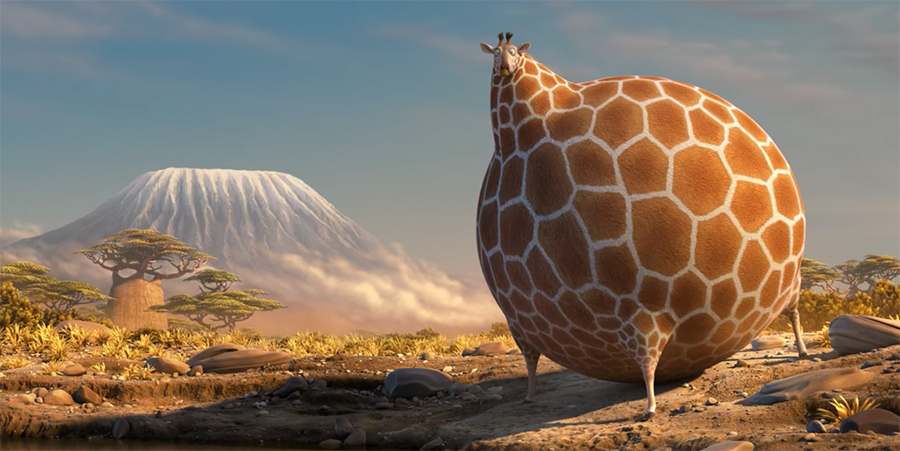

In [57]:
from IPython.display import Image
Image(filename='rollin-wild-giraffe-klonblog.jpg')